#Vorverarbeitung des Review-Datensatzes 
Log: https://data.4tu.nl/articles/dataset/Synthetic_event_logs_-_review_example_large_xes_gz/12716609/1

Review Log wird in Datensatz mit ganzen Instanz-Graphen transformiert

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2



In [ ]:
%%capture
!pip install pm4py

In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
import torch
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Klassen des ReviewLog Datensatzes
Sämtliche Schritte des Preprozessings werden in diesem Modul zusammengefasst und als .py Datei gespeichert

In [ ]:
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
# Speicherort des Moduls
%cd /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
#%%writefile preprocessing/reviewSynthetic.py
import pm4py
import numpy as np
import pandas as pd
import torch as torch

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx

class ReviewSynLog():
  def __init__(self, normalisation, label_encoder):
    self.normalisation = normalisation
    self.label_encoder = label_encoder
    

  def load_dataset(self, path, get_log = False):
    '''
    Datensatz laden
    Args:
      path: Speicherpfad
      get_log (bool, optional): Ob Log Instanz ausgegeben werden soll
    rtype (dataframe, log)
      log optional
    '''
    # Read Dataset
    path = str(path)
    log_a = pm4py.read_xes(path)

    # Transform to Dataframe
    df_a = pm4py.convert_to_dataframe(log_a)

    if get_log == True:
      return df_a, log_a
    return df_a

  def preprocess_data(self, df_log):
    # rename columns
    new_names = {"org:resource":"resource", "time:timestamp": "timestamp", "concept:name": "event_name", "lifecycle:transition": "transition", "case:concept:name": "review_id", "case:description": "description"}
    df_log = df_log.rename(columns = new_names)

    # nutzlose Spalten entfernen
    df_log = df_log.drop(["description", "resource"], axis = 1)

    # NaNs in Result-Spalte entfernen
    df_log["result"] = df_log["result"].fillna("0")

    # Convertieren von Timestamps zu Integer Timestamps
    df_log["timestamp"] = df_log["timestamp"].apply(lambda x: int(round(x.timestamp())))

    # Start und End-Knoten hinzufügen
    df_log = df_log.groupby("review_id").apply(lambda x: self.add_nodes(x))
    df_log.reset_index(drop=True, inplace=True)

    # Label (y-Varbiable) für Process Instanzen erstellen
    df_log = df_log.groupby("review_id").apply(lambda x: self.add_labels(x))
    df_log.reset_index(drop=True, inplace=True)
  

    # review_id zu int-Typ transformieren
    df_log["review_id"] = df_log["review_id"].astype(int)

    # result Spalte enthält int und string Typen. Alle zu string transformieren als Vorbereidung für das Encoding
    # df_log["result"] =df_log["result"].astype(str)
    return df_log

  def encode_data(self, df, feature):
    '''
    Encoded Zellenwerte in Integerwerte.
    args:
      df: DataFrame
      feature: Spaltennamen
      label_encoder (bool): Wenn Werte mit Label encoder verschlüsselt werden sollen True. Ansonsten wird OneHotEncoder und Ordinal Encoder angewendet
    '''

    # Split in X und y
    X = df.drop("result_process", axis = 1)
    y = df["result_process"]

    # Spalten, welche Encoded werden sollen
    col_trans = feature #["resource", "event_name", "transition", "result"]

    if self.label_encoder == True:
      X, encoder = self.label_encoding(X, col_trans)
    else:
      X, encoder = self.one_hot_encoding(X, col_trans)

    # Normalisieren der Feature Werte
    if self.label_encoder == True and self.normalisation == True:
      df_feature = X[col_trans]
      scaler = MinMaxScaler()
      df_feature = pd.DataFrame(scaler.fit_transform(df_feature), 
                                        columns=df_feature.columns, index=df_feature.index)
      X[col_trans] = df_feature
      
    else:
      scaler = None

    # X = X.drop([col_trans], axis = 1)
    # X = pd.concat([X, df_feature], axis = 1)
    # 
    

    return X, y, encoder, scaler

  def label_encoding(self,X, col_trans):
    # Initialisierung der Label Encoder
    d = defaultdict(LabelEncoder)

    # Encoding the variable
    X[col_trans] = X[col_trans].apply(lambda x: d[x.name].fit_transform(x))
    return X, d

  def one_hot_encoding(self, X, col_trans):
    # Encoding
    oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)
    # o_encoder = OrdinalEncoder()

    # Nominale Variablen
    nominal_col = col_trans # ["event_name", "transition", "result"]
    # Ordinale Variablen
    # ordinal_col = ["Timestamp", "ProcessID"] 

    # Encoding Ordinale Spalten
    # X[ordinal_col] = pd.DataFrame(o_encoder.fit_transform(X[ordinal_col]))

    # One Hot Encoding anwenden
    t = pd.DataFrame(oh_encoder.fit_transform(X[nominal_col[:]]))

    # Index reparieren
    t.index = X.index

    # Rename Columns
    t.columns = oh_encoder.get_feature_names(nominal_col[:])

    # Nominale Spalten entfernen und mit den Encoded Spalten ersetzen
    X.drop(nominal_col[:], axis = 1, inplace= True)

    # Zusammenführen der Dataframes
    X_encoded = pd.concat([X, t], axis=1)
    return X_encoded, oh_encoder



  def add_labels(self, group): 
    '''
    Label erstellen, welche ein positives oder negatives Ergebniss des Review Prozesses darstellen. Ergebniss aus X-Daten entfernen. 
    Gruppen welche die benötigten Events nicht enthalten, werden aus dem Datensatz aussortiert
    Positives Event: accept
    Negatives Event: reject
    ''' 
    # Start- und Endknoten einfügen
    #group = self.add_nodes(group)
    if "accept" in group.event_name.values:
      group["result_process"] = 1
      #group = group[group.event_name != "accept"]
      #index_names = group[ (group['event_name'] >= "accept")].index
      #group.drop(index_names, inplace=True)
      group = group[group.event_name != "accept"]
      return group
    elif "reject" in group.event_name.values:
      group["result_process"] = 0
      #index_names = group[ (group['event_name'] >= "reject")].index
      #group.drop(index_names, inplace=True)
      group = group[group.event_name != "reject"]
      return group

  def add_nodes(self, g):
    g.reset_index(drop=True, inplace = True)
    # Timestamp des ersten und letzten Events
    ts_0 = g.iloc[0]["timestamp"]
    ts_1 = g.iloc[-1]["timestamp"]

    # Review-Id der Gruppe
    review_id = g.iloc[0]["review_id"]
    
    # Hinzufügen neuer Reihen
    g.loc[-1] = [ts_0 - 1,"start",'start',review_id, "0"]  # Start-Knoten hinzufügen
    g.loc[len(g.index)] = [ts_1 +1,"end",'start',review_id, "0"] # End-Knoten hinzufügen
    g.index = g.index + 1  # Index anpassen
    g.sort_index(inplace=True) 
    return g



  def get_integer_mapping(self, le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

  # Erhalten der durch das LabelEncoding verschlüsselten ursprünglichen Werte. Output: {node_id: [feature]}
  def get_label(self, nodes, codes):
    node_label = {}
    for n_id, node in enumerate(nodes):
      translations = []
      for id, feature in enumerate(node):  
        #if id != 3:    
        for key, value in codes[id].items():
          if feature == value:
            translations.append(key)
      node_label[n_id] =translations
          #else:
            #node_label.append("error: " + str(node.item()))

    return node_label

  


class CreateDatasetReview(InMemoryDataset):
  '''
  Quelle: https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
  PyG: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
  '''
  def __init__(self, root, df, feature, device, transform=None, pre_transform=None):
      self.df = df
      self.feature_nodes = feature
      self.device = device
      super(CreateDatasetReview, self).__init__(root, transform, pre_transform)
      self.data, self.slices = torch.load(self.processed_paths[0])
      

  @property
  def raw_file_names(self):
      return []
  @property
  def processed_file_names(self):
      return ['./review_dataset_startnodes.dataset'] #'./xgnn_ppm.dataset'
      

  def download(self):
      pass
    
  # def get_node_ids(self):
  #     return self.node_ids

  def process(self):
    
    data_list = []

    # Definieren ob GPU oder CPU verwendet wurde
    device = self.device

    # process by session_id
    grouped = self.df.groupby('review_id')

    # Define group to be explained in the TestSet
    # X_test = df_log_a[df_log_a["review_id"]==8]
    
    for reviewId, group in tqdm(grouped):           
        # Neue Ids für items in einer Session (von 0 startend)
        # group = group.sort_values("timestamp")                  
        features = self.feature_nodes

        # 1) Knoten-Funktion
        # Node-ID erstellen: Node_id identifiziert Knoten eindeutig. Knoten mit gleichen Features erhalten die selbe -node_id-
        ids =  pd.factorize(group[features].apply(tuple, axis=1))[0] 
        group["node_id"] = ids
        #self.node_ids.append(ids)
                  
        # Knoten-Matrix (node_features) erstellen: Matrix (N,F) aller Knoten (N) und deren Features (F) erstellen: Feature sind durch die Variable -features- definiert. Duplikate werden entfernt. -node_id- Spalte wird ebenfalls entfernt, da diese nicht als Feature einbezogen wird
        node_features = group.loc[group.review_id==reviewId,["node_id"]+ features].sort_values('node_id').drop_duplicates(subset=["node_id"]).drop(columns = ["node_id"]).values
        # node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').drop_duplicates(subset = ["sess_item_id"]).values 
        
        #Tensor mit Knoten erstellen
        node_features = torch.from_numpy(node_features).float().to(device) #.unsqueeze(1)

        # 2) Kanten-Funktion
        # Ziel und Start Knoten definieren: 
        target_nodes = group.node_id.values[1:]
        source_nodes = group.node_id.values[:-1]
        x = node_features
        
        # -edge_index-: Tensor bestehend aus zwei gleich langen Listen, welche Verbindungen zwischen Knoten definieren. Tensor([start_knoten_id][ziel_knoten_id])
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)            
        
        # 3) Label zuweisen
        # Tensor mit Label des Graphen (Shape: (1,))
        y = torch.cuda.FloatTensor([group.result_process.values[0]])
        #y = torch.cuda.FloatTensor(label)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    
    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])
    #return data_list


##EVorverarbeitung durchführen

In [ ]:
# ACHTUNG: Add nodes auskommentirert
# initialisieren der ReviewSynLog Klasse
normalization = False
label_encoder = False # Wurde zu Beginn ausprobiert
review_dataset = ReviewSynLog(normalization, label_encoder)

In [ ]:
# Spalten, welche als Knoten-Feature verwendet werden
# 1. Alternative: Mehrere Feature
feature = ['event_name', "result", "transition"]
# 2. Alternative: Ein Feaure
#feature = ["event_name"]

In [ ]:
# Laden des Datensatzes
#path = "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/datasets/Syn_Log/review_example_large.xes"
df, log_review = review_dataset.load_dataset(path / "datasets/Syn_Log/review_example_large.xes", True)

parsing log, completed traces ::   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Sicherheitskopie
df1 = df.copy()

In [ ]:
df1.head(20)

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,result
0,Mike,2006-01-01 00:00:00+01:00,invite reviewers,start,1,Simulated process instance,NaN
1,Mike,2006-01-05 00:00:00+01:00,invite reviewers,complete,1,Simulated process instance,NaN
2,Mary,2006-01-05 00:00:00+01:00,get review 3,complete,1,Simulated process instance,reject
3,Pam,2006-01-06 00:00:00+01:00,get review 1,complete,1,Simulated process instance,reject
4,__INVALID__,2006-01-15 00:00:00+01:00,time-out 2,complete,1,Simulated process instance,NaN
5,Anne,2006-01-16 00:00:00+01:00,collect reviews,start,1,Simulated process instance,NaN
6,Anne,2006-01-16 00:00:00+01:00,collect reviews,complete,1,Simulated process instance,NaN
7,Wil,2006-01-16 00:00:00+01:00,decide,start,1,Simulated process instance,NaN
8,Wil,2006-01-17 00:00:00+01:00,decide,complete,1,Simulated process instance,NaN
9,Mike,2006-01-17 00:00:00+01:00,invite additional reviewer,start,1,Simulated process instance,NaN


In [ ]:
# Preprocessing durchführen
df1 = review_dataset.preprocess_data(df1)

In [ ]:
df2 = df1.copy()

In [ ]:
df2.head()

,timestamp,event_name,transition,review_id,result,result_process
0,1136069999,start,start,1,0,0
1,1136070000,invite reviewers,start,1,0,0
2,1136415600,invite reviewers,complete,1,0,0
3,1136415600,get review 3,complete,1,reject,0
4,1136502000,get review 1,complete,1,reject,0


### Encoding
Im Folgendne wurden verschiedene Encoder (Label Encoder, OneHotEncoder) ausprobiert. Der Label Encoder weist Werten Zahlen zu. Er bewirkt dass die Anzahl von Features gleich bleibt und der Wertebereich als Integer dargestellt wird. Da nominale Werte keine hierarchische Ordnung besitzen, kann die direkte Transformation in Zahlen zu einer falschen hierarchischen Anordnung führen. Der OneHotEncoder erstellt für jeden Wert eines Features eine eigene Spalte. Hierdurch entsteht eine große Anzahl von Binären Featuren, wodurch eine hierarchische Anordnung vermieden wird. Es wurde getestet, welcher Encoder sich besser für die verschiedenen XAI-Methoden eignet.

In [ ]:
# Encoding der X-Feaute durchführen
X, y, encoder, scaler = review_dataset.encode_data(df2, feature)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X.head()

,timestamp,review_id,event_name_collect reviews,event_name_decide,event_name_end,event_name_get review 1,event_name_get review 2,event_name_get review 3,event_name_get review X,event_name_invite additional reviewer,event_name_invite reviewers,event_name_start,event_name_time-out 1,event_name_time-out 2,event_name_time-out 3,event_name_time-out X,result_0,result_accept,result_reject,transition_complete,transition_start
0,1136069999,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1136070000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1136415600,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1136415600,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1136502000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
# Liste der Knoten-Feature in X + review_id
feature_encoded = list(X.loc[ : ,~X.columns.isin(['review_id', "timestamp"])].columns)
feature_encoded

['event_name_collect reviews',
 'event_name_decide',
 'event_name_end',
 'event_name_get review 1',
 'event_name_get review 2',
 'event_name_get review 3',
 'event_name_get review X',
 'event_name_invite additional reviewer',
 'event_name_invite reviewers',
 'event_name_start',
 'event_name_time-out 1',
 'event_name_time-out 2',
 'event_name_time-out 3',
 'event_name_time-out X',
 'result_0',
 'result_accept',
 'result_reject',
 'transition_complete',
 'transition_start']

In [ ]:
# X und y zu einem Dataframe zusammenführen für das erstellen des Datensets
df3 = pd.concat([X,y], axis = 1)

In [ ]:
df3.head()

,timestamp,review_id,event_name_collect reviews,event_name_decide,event_name_end,event_name_get review 1,event_name_get review 2,event_name_get review 3,event_name_get review X,event_name_invite additional reviewer,event_name_invite reviewers,event_name_start,event_name_time-out 1,event_name_time-out 2,event_name_time-out 3,event_name_time-out X,result_0,result_accept,result_reject,transition_complete,transition_start,result_process
0,1136069999,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,1136070000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,1136415600,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,1136415600,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,1136502000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0


In [ ]:
#%cd "/content/"

In [ ]:
process_path  = "/content/drive/MyDrive/Rep_Masterarbeit/"

In [ ]:
# Erstellen eines PyTorch Geometric Datasets mit Instanz-Graphen
dataset = CreateDatasetReview(root=process_path, df = df3, feature = feature_encoded, device = device) 

Processing...


100%|██████████| 10000/10000 [00:52<00:00, 191.29it/s]


Done!


### Visualisierung

In [ ]:
data = dataset[5]

In [ ]:
feature_encoded

In [ ]:
from utilities_preprocessing import GraphDatasetHelper

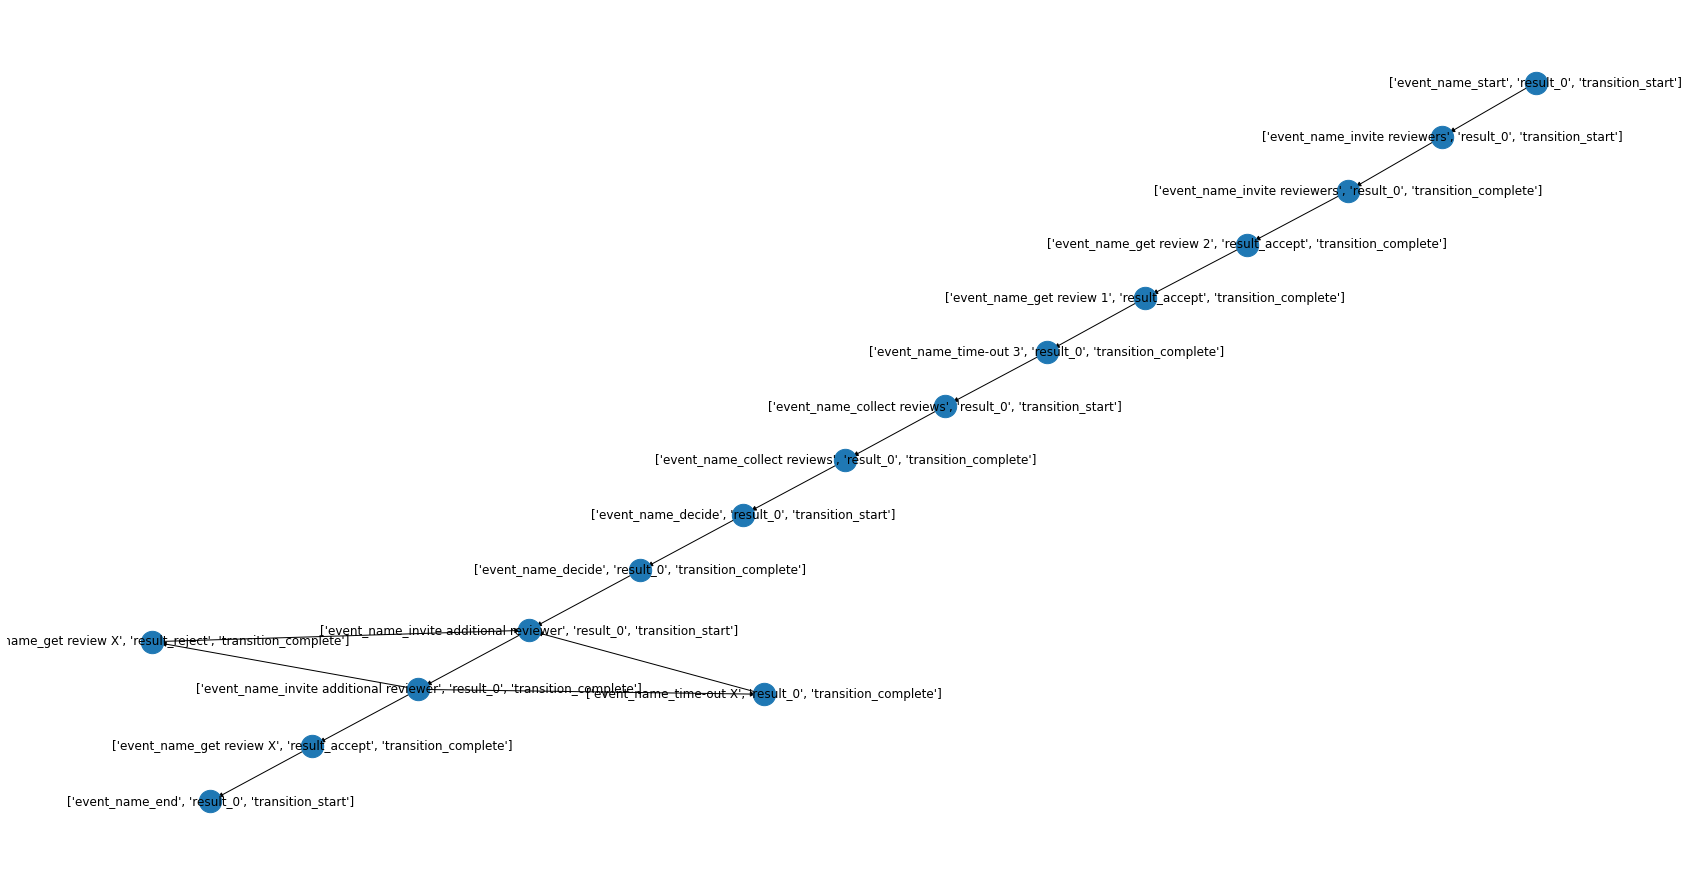

In [ ]:
# Namen können nur bei label encoder angezeigt werden
helper = GraphDatasetHelper(node_feature = feature_encoded)
helper.visualize_dataset(data)

### Datensatz speichern

Speicherformat: **datensatzname_startknoten_featureanzahl_encoding**

In [ ]:
dataset_name = "review_sn_f3_ohe_2"

In [ ]:
import joblib
# Datensatz speichern
torch.save(dataset, path / str("datasets/dataset_" + dataset_name) )
# Labelencoder speicher 
joblib.dump(feature_encoded , "datasets/encoder_" + dataset_name + ".joblib")

['datasets/encoder_review_sn_f3_ohe_2.joblib']

In [ ]:
label_encoder = joblib.load("datasets/encoder_" + dataset_name + ".joblib")
label_encoder

In [ ]:
# dataset2 = torch.load(path / "datasets/dataset_review_sn_f1_le")

## Log Analyse

In [ ]:
# gz unpack:
# import gzip
# import shutil
# with gzip.open(file_path +".gz", 'rb') as f_in:
#     with open(file_path, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

### Prozess-Analyse

Im Folgenden wird analysiert wie der Prozess aus einer globalen Sicht (unter einbezug des gesammten Logs) aufgebaut ist. Hierzu wird das Package pm4py verwendet. Es wird ein Verständnis über die Funktion der einzelnen Events im Prozess geschaffen.

### BPMN

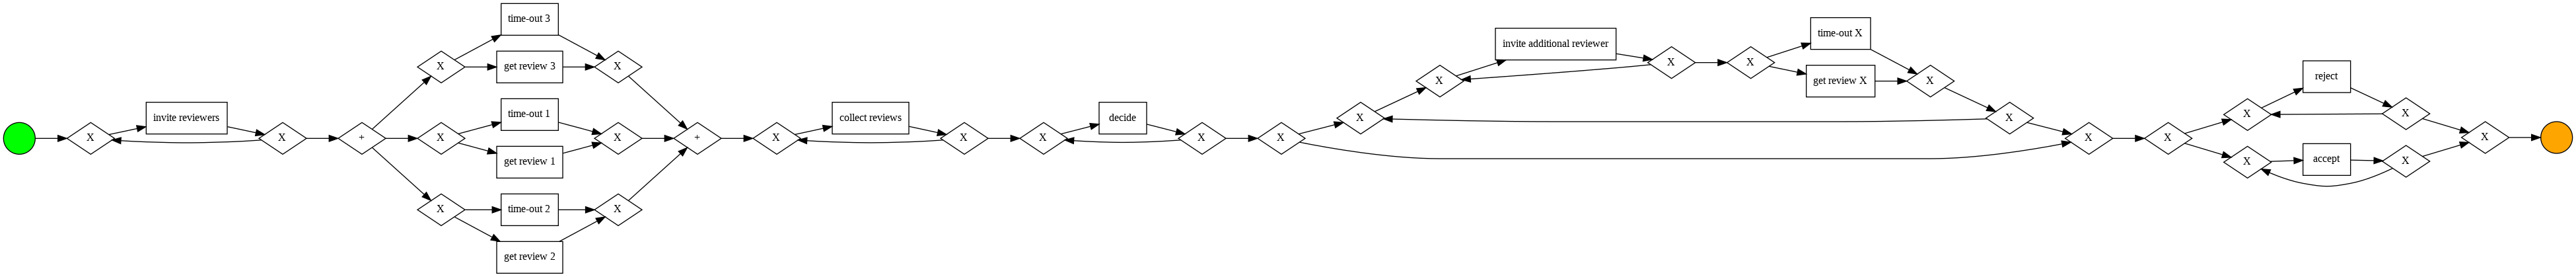

In [ ]:
  process_model = pm4py.discover_bpmn_inductive(log_review)
  pm4py.view_bpmn(process_model)

### Directly Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

https://pm4py.fit.fraunhofer.de/documentation#evaluation



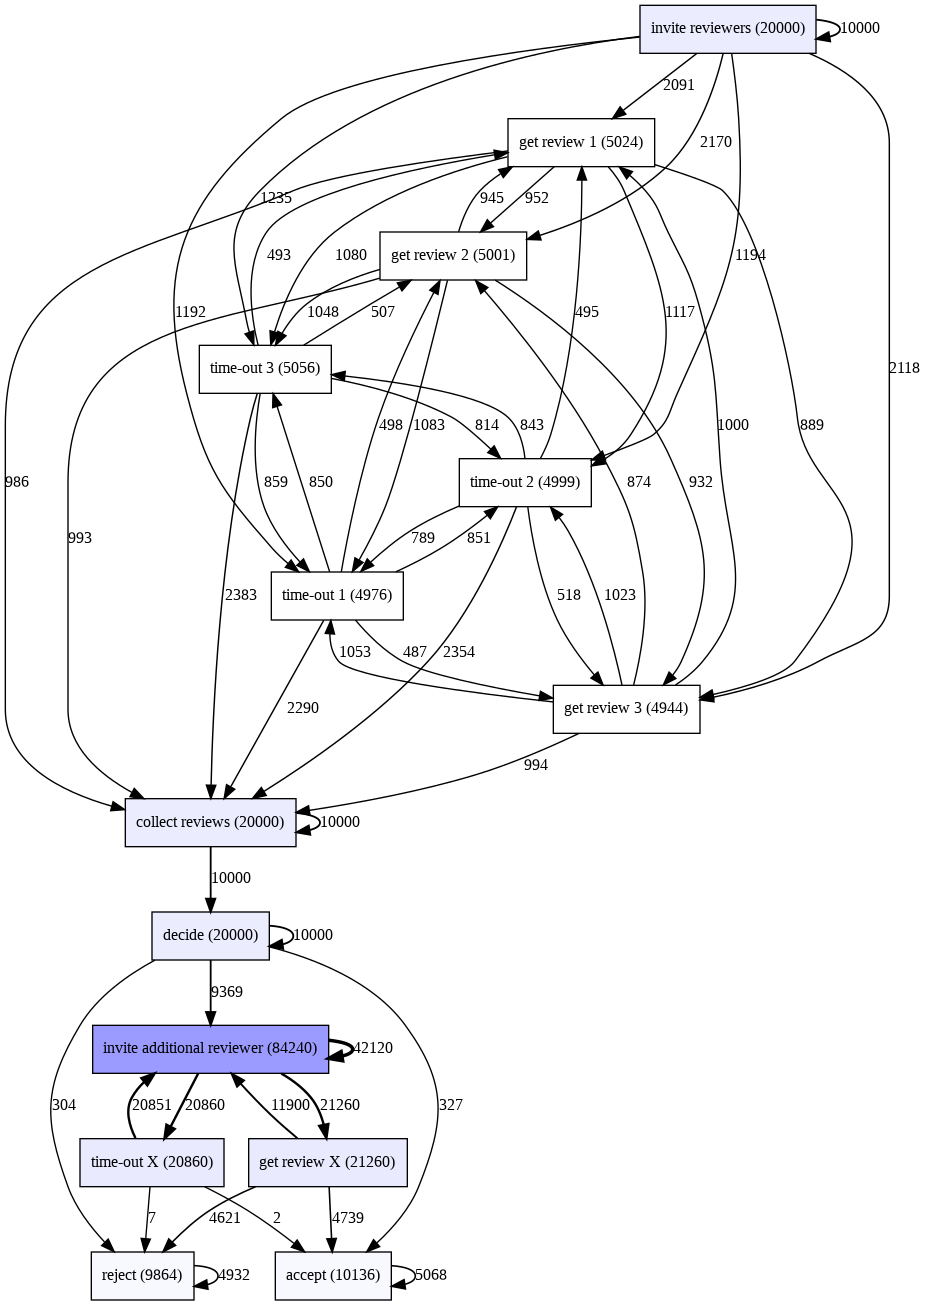

In [ ]:
from pm4py.algo.discovery.dfg import algorithm  as dfg_factory
from pm4py.visualization.dfg import visualizer  as dfg_vis_factory

dfg = dfg_factory.apply(log_review)
gviz = dfg_vis_factory.apply(dfg, log=log_review)
dfg_vis_factory.view(gviz)

### Analyse des Dataframes

#### Ursprungs-DF

In [ ]:
# Erste Beschreibung der Daten
df.describe()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,result
count,236360,236360,236360,236360,236360,236360,36229
unique,11,70956,14,2,10000,1,2
top,Anne,2131-03-01 00:00:00+01:00,invite additional reviewer,complete,9729,Simulated process instance,accept
freq,72158,23,84240,154240,86,236360,18244


In [ ]:
# Klassenverteilung
df1.groupby("result_process")["review_id"].nunique()

result_process
0    4932
1    5068
Name: review_id, dtype: int64

## Preprocess Data

Während des Preprocessings werden verschiedene Opterationen am Datensatz durchgeführt. Diese sind alle in ihrer finalen Form im obigen Feld enthalten. Hier werden die Operationen einzeln dargestellt und ihre Auswirkung auf den Datensatz gezeigt



### Rename Columns, Drop Columns & Fill NaN

In [ ]:
# rename columns
new_names = {"org:resource":"resource", "time:timestamp": "timestamp", "concept:name": "event_name", "lifecycle:transition": "transition", "case:concept:name": "review_id", "case:description": "description"}
df_log = df_log.rename(columns = new_names)
df_log.head()

,resource,timestamp,event_name,transition,review_id,description,result
0,Mike,2006-01-01 00:00:00+01:00,invite reviewers,start,1,Simulated process instance,NaN
1,Mike,2006-01-05 00:00:00+01:00,invite reviewers,complete,1,Simulated process instance,NaN
2,Mary,2006-01-05 00:00:00+01:00,get review 3,complete,1,Simulated process instance,reject
3,Pam,2006-01-06 00:00:00+01:00,get review 1,complete,1,Simulated process instance,reject
4,__INVALID__,2006-01-15 00:00:00+01:00,time-out 2,complete,1,Simulated process instance,NaN


In [ ]:
# drop useless columns
df_log = df_log.drop(columns="description")
df_log.head()

,resource,timestamp,event_name,transition,review_id,result
0,Mike,2006-01-01 00:00:00+01:00,invite reviewers,start,1,NaN
1,Mike,2006-01-05 00:00:00+01:00,invite reviewers,complete,1,NaN
2,Mary,2006-01-05 00:00:00+01:00,get review 3,complete,1,reject
3,Pam,2006-01-06 00:00:00+01:00,get review 1,complete,1,reject
4,__INVALID__,2006-01-15 00:00:00+01:00,time-out 2,complete,1,NaN


In [ ]:
# preprocess NaNs
df_log.isna().sum()

resource           0
timestamp          0
event_name         0
transition         0
review_id          0
result        200131
dtype: int64

df_log["result"] = df_log["result"].fillna(0)
df_log.head()

### Add Nodes
# Start- und End-Knoten zu einer Prozess-Instanz hinzufügen

In [ ]:
def add_nodes(g):
    g.reset_index(drop=True, inplace = True)
    # Timestamp des ersten und letzten Events
    ts_0 = g.iloc[0]["time:timestamp"]
    ts_1 = g.iloc[-1]["time:timestamp"]

    # Review-Id der Gruppe
    review_id = g.iloc[0]["case:concept:name"]
    
    # Hinzufügen neuer Reihen
    g.loc[-1] = ["__INVALID__",ts_0 - 1,"start",'start',review_id,"a", "0"]  # Start-Knoten hinzufügen
    g.loc[len(g.index)] = ["__INVALID__",ts_1 +1,"end",'start',review_id, "a",  "0"] # End-Knoten hinzufügen
    g.index = g.index + 1  # Index anpassen
    g.sort_index(inplace=True) 
    return g

In [ ]:
group = df.groupby("case:concept:name")

In [ ]:
g = next(iter(group))[1]
g["time:timestamp"]  =g["time:timestamp"].apply(lambda x: int(round(x.timestamp())))


In [ ]:
# Hier ist der Abstand vom End-Knoten zu seinem Vorgänger eins. Später wird dieser größer sein, da das Vorgängerevent Accept/ Reject ist und daher entfernt wird
# Ist nicht schlimm, da die Timestamps nicht als Feature in das Model-Training einfließen
g  

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,result
0,Mike,1136070000,invite reviewers,start,1,Simulated process instance,NaN
1,Mike,1136415600,invite reviewers,complete,1,Simulated process instance,NaN
2,Mary,1136415600,get review 3,complete,1,Simulated process instance,reject
3,Pam,1136502000,get review 1,complete,1,Simulated process instance,reject
4,__INVALID__,1137279600,time-out 2,complete,1,Simulated process instance,NaN
5,Anne,1137366000,collect reviews,start,1,Simulated process instance,NaN
6,Anne,1137366000,collect reviews,complete,1,Simulated process instance,NaN
7,Wil,1137366000,decide,start,1,Simulated process instance,NaN
8,Wil,1137452400,decide,complete,1,Simulated process instance,NaN
9,Mike,1137452400,invite additional reviewer,start,1,Simulated process instance,NaN


In [ ]:
b = add_nodes(g)
b

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name,case:description,result
0,__INVALID__,1136069999,start,start,1,a,0
1,Mike,1136070000,invite reviewers,start,1,Simulated process instance,NaN
2,Mike,1136415600,invite reviewers,complete,1,Simulated process instance,NaN
3,Mary,1136415600,get review 3,complete,1,Simulated process instance,reject
4,Pam,1136502000,get review 1,complete,1,Simulated process instance,reject
5,__INVALID__,1137279600,time-out 2,complete,1,Simulated process instance,NaN
6,Anne,1137366000,collect reviews,start,1,Simulated process instance,NaN
7,Anne,1137366000,collect reviews,complete,1,Simulated process instance,NaN
8,Wil,1137366000,decide,start,1,Simulated process instance,NaN
9,Wil,1137452400,decide,complete,1,Simulated process instance,NaN


### Create Label

Label erstellen, welches ein positives oder negatives Ergebnis des Review Prozesses darstellt. Dieses wird aus den event_names 'accept' und 'reject' abgeleitet. Ergebnis aus X Daten entfernen

In [ ]:
def find_process_result(group):  
  if "accept" in group.event_name.values:
    group["result_process"] = 1
    #group = group[group.event_name != "accept"]
    #index_names = group[ (group['event_name'] >= "accept")].index
    #group.drop(index_names, inplace=True)
    group = group[group.event_name != "accept"]
    return group
  elif "reject" in group.event_name.values:
    group["result_process"] = 0
    #index_names = group[ (group['event_name'] >= "reject")].index
    #group.drop(index_names, inplace=True)
    group = group[group.event_name != "reject"]
    return group


In [ ]:
# create collumn for result of whole Process
df_log_a = df_log.groupby("review_id").apply(lambda x: find_process_result(x))


In [ ]:
df_log_a.reset_index(drop=True, inplace=True)
df_log_a.head()

,resource,timestamp,event_name,transition,review_id,result,result_process
0,Mike,2006-01-01 00:00:00+01:00,invite reviewers,start,1,0,0
1,Mike,2006-01-05 00:00:00+01:00,invite reviewers,complete,1,0,0
2,Mary,2006-01-05 00:00:00+01:00,get review 3,complete,1,reject,0
3,Pam,2006-01-06 00:00:00+01:00,get review 1,complete,1,reject,0
4,__INVALID__,2006-01-15 00:00:00+01:00,time-out 2,complete,1,0,0


In [ ]:
# Get distribution of lables
df_log_a.result_process.value_counts()

1    110235
0    106125
Name: result_process, dtype: int64

### Zeitstempel convertieren in Datetimes

Zeitstempel in Datetimes transformieren und Dauer von Events berechnen

Mögliche Feature: 
- timestamp: Datetime (DT)
- duration: 
  - 1. Fall: Event mit start/complete transition (e1): DT2 - DT1
  - 2. Fall: Event nur mit complete transition (e2): DT(e2) - DT(e1)

In [ ]:
import time
import datetime

In [ ]:
df2.head(30)

In [ ]:
# Convertieren von Timestamps zu Integer Timestamps
df2["timestamp"] = df2["timestamp"].apply(lambda x: int(round(x.timestamp())))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df3.head()

,resource,timestamp,event_name,transition,review_id,result,result_process
0,4,1136070000,7,1,1,0,0
1,4,1136415600,7,0,1,0,0
2,3,1136415600,4,0,1,2,0
3,5,1136502000,2,0,1,2,0
4,10,1137279600,9,0,1,0,0


In [ ]:
df3_normalized = pd.DataFrame(scaler.fit_transform(df3), 
                                      columns=df3.columns, index=df2.index)

In [ ]:
df3_normalized.head()

,resource,timestamp,event_name,transition,review_id,result,result_process
0,0.4,0.000000,0.636364,1.0,0.0,0.0,0.0
1,0.4,0.000044,0.636364,0.0,0.0,0.0,0.0
2,0.3,0.000044,0.363636,0.0,0.0,1.0,0.0
3,0.5,0.000055,0.181818,0.0,0.0,1.0,0.0
4,1.0,0.000155,0.818182,0.0,0.0,0.0,0.0


In [ ]:
df2.head()

,resource,timestamp,event_name,transition,review_id,result,result_process
0,Mike,1136070000,invite reviewers,start,1,0,0
1,Mike,1136415600,invite reviewers,complete,1,0,0
2,Mary,1136415600,get review 3,complete,1,reject,0
3,Pam,1136502000,get review 1,complete,1,reject,0
4,__INVALID__,1137279600,time-out 2,complete,1,0,0


###Transform Types of Values mit LabelEncoder

Damit Modell Trainiert werden kann müssen int Types vorliegen

In [ ]:
# Transform result to int
df_log_a["review_id"] = df_log_a["review_id"].astype(int)
df_log_a["result"] =df_log_a["result"].astype(str)
df_log_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216360 entries, 0 to 216359
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   resource        216360 non-null  object
 1   timestamp       216360 non-null  object
 2   event_name      216360 non-null  object
 3   transition      216360 non-null  object
 4   review_id       216360 non-null  int64 
 5   result          216360 non-null  object
 6   result_process  216360 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 11.6+ MB


In [ ]:
#df_log_b.info()

In [ ]:
df_log_b = df_log_a.copy()
col_trans = ["resource", "timestamp", "event_name", "transition", "result"]

In [ ]:
d = defaultdict(LabelEncoder)

# Encoding the variable
df_log_b[col_trans] = df_log_b[col_trans].apply(lambda x: d[x.name].fit_transform(x))



In [ ]:
df_log_b.head()

,resource,timestamp,event_name,transition,review_id,result,result_process
0,4,0,8,1,1,0,0
1,4,1,8,0,1,0,0
2,3,1,5,0,1,2,0
3,5,2,3,0,1,2,0
4,10,7,10,0,1,0,0


In [ ]:
len(df_log_b)

226496

## Lösen des Self-Loops Problems

XAI-Methoden werfen einen Fehler (weil sie GCN im explain Modus verwenden). Daher sollten keine Selbsloops im Datensatz enthalten sein



Testen, ab wann invite additional reviewer zu einer Eigenschleife führt

In [ ]:
df_s = df2[(df2["event_name"] == "invite additional reviewer") ]  #& (df2["transition"] == "start")


In [ ]:
for i in range(df_s.shape[0]):
  if df_s.iloc[i]["transition"] == df_s.iloc[i+1]["transition"]:
    print(df_s.iloc[i]["review_id"])
  elif (df_s.shape[0] -2) == i:
    print("nothing found")
    break
  

nothing found


In [ ]:
# Dataframe auf für das Dataframe relevante Spalten eingrenzen
df2 = df2[feature + ["result_process", "review_id", "timestamp" ]]


In [ ]:
df2.head(20)

In [ ]:
df_encoded = X[(X["event_name_invite additional reviewer"] == 1) ]

In [ ]:
for i in range(df_encoded.shape[0]):
  if df_encoded.iloc[i]["transition_start"] == df_encoded.iloc[i+1]["transition_start"]:
    print(df_encoded.iloc[i]["review_id"])
  elif (df_encoded.shape[0] -2) == i:
    print("nothing found")
    break

nothing found


In [ ]:
gs = df3.groupby("review_id")


In [ ]:
for pos, (i,g) in enumerate(gs): 
  if pos == 8045:
    g_f = g
    print("found")
    break



found


dataset

In [ ]:
g_f[["timestamp","event_name_invite additional reviewer",  "transition_complete","transition_start"] ]  # Durch das Sortieren der Timestamps, kann die Reihenfolge falsch verändert werden, wenn die Timestamps gleich sind

,timestamp,event_name_invite additional reviewer,transition_complete,transition_start
185606,4585244399,0.0,0.0,1.0
185607,4585244400,0.0,0.0,1.0
185608,4585676400,0.0,1.0,0.0
185609,4585935600,0.0,1.0,0.0
185610,4586022000,0.0,1.0,0.0
185611,4586194800,0.0,1.0,0.0
185612,4586626800,0.0,0.0,1.0
185613,4586886000,0.0,1.0,0.0
185614,4586886000,0.0,0.0,1.0
185615,4587231600,0.0,1.0,0.0
